In [4]:
import os
import util
from scipy import sparse
import numpy as np
from collections import Counter
import pandas as pd
import random
from matplotlib import pyplot as plt

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

In [2]:
def check_all(start_index, end_index, direc):
    classes = []
    ids = [] 
    processes = []
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break
        
        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        tree = ET.parse(os.path.join(direc,datafile))
        
        ''processList = []
        for el in tree.iter() :
            processList.append(el.tag)
        processes.append(processList)
''
    return np.array(classes), ids, processes

In [ ]:
y, ids, processes = check_all(0, 3086, 'train')
lengths = [len(process) for process in processes]

In [5]:
df = pd.DataFrame()
df['class'] = y
df['ids'] = ids
df['lengths'] = lengths

In [12]:
def contains_sublist(lst, sublst):
    n = len(sublst)
    return any([(sublst == lst[i:i+n]) for i in xrange(len(lst)-n+1)])

def substring(n,m,minLength=5) :
    start = 0
    while start < len(n) - 5 :
        exists = True
        while exists == True and (start + minLength) < len(n):
            exists = contains_sublist(m, n[start:start+minLength])
            minLength += 1
        start += 1
    return minLength/float(len(n))

def most_common(lst):
    return max(set(lst), key=lst.count)

def capMask(old_vector, limit) :
    vector = old_vector[:]
    if np.sum(vector) > limit :
        falseMask = random.sample(np.where(np.array(vector) == True)[0].tolist(), (np.sum(vector) - limit))
        for sample in falseMask :
            vector[sample] = False
        return vector
    else :
        return vector

def bestMatch(unknown, allProcesses, lengths, y, df, minLength, error) :
    u_length = len(unknown)
    mask = [True if (length-error) <= u_length <= (length+error) else False for length in lengths]
    
    if np.sum(mask) == 1 :
        return [el[1] for el in zip(mask,y) if el[0] == True][0]
    elif u_length < 1500 :
        new_mask = capMask(mask, 20)
        dftouse = df[new_mask]
        processtouse = [el[1] for el in zip(new_mask,allProcesses) if el[0] == True]

        withScores = dftouse.copy()
        withScores['scores'] = [substring(unknown, process) for process in processtouse]
        topClasses = withScores[withScores.scores > 0.8].sort(['scores'], ascending=False)['class'].tolist()
        if len(topClasses) > 0 :
            return most_common(topClasses)
        else :
            return -1
    else :
        return 'Too hard! :('

In [13]:
try :
    train_pred = np.load('train_pred.npy').tolist()
except IOError: 
    train_pred = []
    
start = len(train_pred)
for i in range(start,3086) :
    print i
    train_pred.append(bestMatch(processes[i], processes, lengths, y, df, minLength=5, error=0))
    np.save('train_pred.npy',np.array(train_pred))

236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462


KeyboardInterrupt: 

In [14]:
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def accuracy_score(arr1, arr2) :
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    
    if arr1.shape == arr2.shape :
        print 'Accuracy: ' + str(len(np.where(arr1 == arr2)[0])/float(arr1.shape[0]))
    
    plt.scatter(rand_jitter(arr1), rand_jitter(arr2), alpha=0.1);
    plt.xlabel('Predictions');
    plt.ylabel('True classification');

Accuracy: 0.961038961039


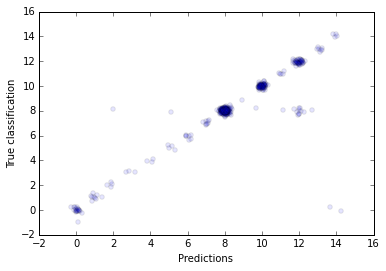

In [15]:
%matplotlib inline
train_pred = np.load('train_pred.npy')
y_pred = [int(el) if el != 'Too hard! :(' else 8 for el in train_pred.tolist()]
n = len(y_pred)
accuracy_score(y[0:n],np.array(y_pred))